# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size
num_classes = 5  #number of softmax classes

In [5]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


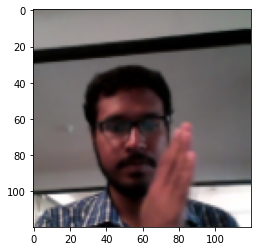

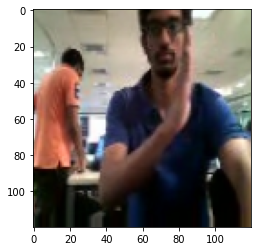

In [6]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imread("/home/datasets/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imread("/home/datasets/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size, x=20,y=120,z=120,augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30
    img_idx = np.round(np.linspace(0,total_frames-1,x)).astype(int)#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)   
                    
                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, x,y,z,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
import datetime

curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)



# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


#write your model here

#Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [9]:
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 activatio

2024-05-01 05:40:07.552384: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-01 05:40:07.552448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
# optimiser = #write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR] 

In [11]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [13]:
# train_generator = generator(train_path, train_doc, batch_size)
# val_generator = generator(val_path, val_doc, batch_size)

callbacks_list = model_callbacks("conv3D_model_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames)

In [14]:
# callbacks_list = model_callbacks("conv3D_model_1")

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [15]:
# def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
#     if (num_train_sequences%batch_size) == 0:
#         steps_per_epoch = int(num_train_sequences/batch_size)
#     else:
#         steps_per_epoch = (num_train_sequences//batch_size) + 1

#     if (num_val_sequences%batch_size) == 0:
#         validation_steps = int(num_val_sequences/batch_size)
#     else:
#         validation_steps = (num_val_sequences//batch_size) + 1

#     return steps_per_epoch,validation_steps

In [16]:
# steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)


In [17]:
steps_per_epoch, validation_steps, train_generator, val_generator

(67,
 10,
 <generator object generator at 0x7f03561ab3c0>,
 <generator object generator at 0x7f03561ab190>)

In [18]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15


2024-05-01 05:40:15.646091: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5562 - categorical_accuracy: 0.4389Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to conv3D_model_1_2024-05-0105_40_06.663523/model-00001-1.55616-0.43891-6.38598-0.16000.h5
67/67 [==============================] - 165s 2s/step - loss: 1.5562 - categorical_accuracy: 0.4389 - val_loss: 6.3860 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.4385 - categorical_accuracy: 0.4630
Epoch 00002: saving model to conv3D_model_1_2024-05-0105_40_06.663523/model-00002-1.43853-0.46305-3.68715-0.21000.h5
67/67 [==============================] - 163s 2s/step - loss: 1.4385 - categorical_accuracy: 0.4630 - val_loss: 3.6872 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.2577 - categorical_accuracy: 0.5053
Epoch 00003: saving model to conv3D_model_1_2024-05-0105_40_

### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [19]:
num_epochs = 20 
batch_size = 10 
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch

In [20]:
callbacks_list = model_callbacks("conv3D_model_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames)

In [21]:
result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_239/1582063963.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5622 - categorical_accuracy: 0.4449Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to conv3D_model_2_2024-05-0105_40_06.663523/model-00001-1.56222-0.44495-2.41445-0.23000.h5
67/67 [==============================] - 110s 2s/step - loss: 1.5622 - categorical_accuracy: 0.4449 - val_loss: 2.4144 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3148 - categorical_accuracy: 0.5219
Epoch 00002: saving model to conv3D_model_2_2024-05-0105_40_06.663523/model-00002-1.31485-0.52187-3.32703-0.23000.h5
67/67 [==============================] - 115s 2s/step - loss: 1.3148 - categorical_accuracy: 0.5219 - val_loss: 3.3270 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1199 - categorical_accuracy: 0.5747
Epoch 00003: saving model to conv3D_model_2_2024-

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


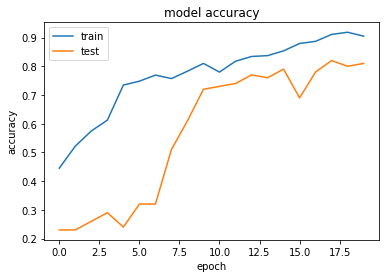

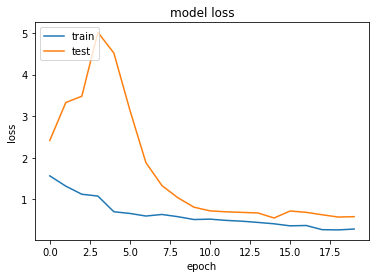

In [22]:
plot_loss_accuracy(result)

### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)¶


In [23]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                            

In [24]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames,y=160, z=160)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames,y=160, z=160)

In [25]:
result3 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.5864 - categorical_accuracy: 0.4389Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_conv3D_3_2024-05-0105_40_06.663523/model-00001-1.58638-0.43891-4.06320-0.21000.h5
67/67 [==============================] - 202s 3s/step - loss: 1.5864 - categorical_accuracy: 0.4389 - val_loss: 4.0632 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0663 - categorical_accuracy: 0.5792
Epoch 00002: saving model to model_conv3D_3_2024-05-0105_40_06.663523/model-00002-1.06630-0.57919-3.85369-0.19000.h5
67/67 [==============================] - 171s 3s/step - loss: 1.0663 - categorical_accuracy: 0.5792 - val_loss: 3.8537 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8832 - categorical

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


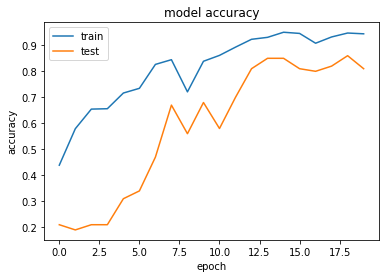

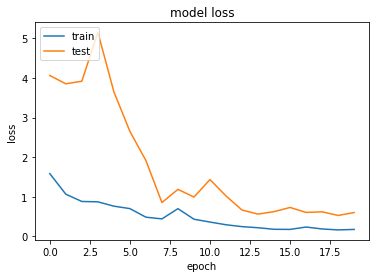

In [26]:
plot_loss_accuracy(result3)

### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)



In [27]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                            

In [28]:
callbacks_list = model_callbacks("conv3D_model_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames, y=160, z=160)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames, y=160, z=160)

In [29]:
result4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_239/2526774381.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6271 - categorical_accuracy: 0.4314Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to conv3D_model_4_2024-05-0105_40_06.663523/model-00001-1.62714-0.43137-3.10035-0.21000.h5
67/67 [==============================] - 126s 2s/step - loss: 1.6271 - categorical_accuracy: 0.4314 - val_loss: 3.1003 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1156 - categorical_accuracy: 0.5882
Epoch 00002: saving model to conv3D_model_4_2024-05-0105_40_06.663523/model-00002-1.11562-0.58824-4.06311-0.25000.h5
67/67 [==============================] - 129s 2s/step - loss: 1.1156 - categorical_accuracy: 0.5882 - val_loss: 4.0631 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9273 - categorical_accuracy: 0.6350
Epoch 00003: saving model to conv3D_model_4_2024-

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


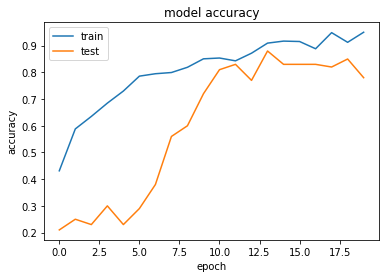

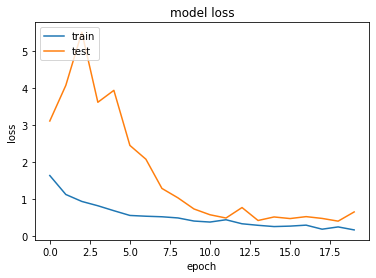

In [30]:
plot_loss_accuracy(result4)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [12]:
from keras.applications import mobilenet
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D,LSTM,Conv2D, MaxPooling2D, TimeDistributed


def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes


In [32]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120



# epochs = 15
# batch size = 10
# num frames per video = 20


In [33]:

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

17235968/17225924 [==============================] - 2s 0us/step
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       

#### The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [34]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames)

In [35]:
result_conv2d_gru = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10


/tmp/ipykernel_239/3886520124.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result_conv2d_gru = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.2545 - categorical_accuracy: 0.4947Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_retrain_mobilenet_gru_2024-05-0105_40_06.663523/model-00001-1.25451-0.49472-0.85239-0.65000.h5
67/67 [==============================] - 115s 2s/step - loss: 1.2545 - categorical_accuracy: 0.4947 - val_loss: 0.8524 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.6546 - categorical_accuracy: 0.7511
Epoch 00002: saving model to model_retrain_mobilenet_gru_2024-05-0105_40_06.663523/model-00002-0.65458-0.75113-0.50436-0.81000.h5
67/67 [==============================] - 109s 2s/step - loss: 0.6546 - categorical_accuracy: 0.7511 - val_loss: 0.5044 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.4220 - categorical_accuracy: 0.8431
Epoch 00003: saving mod

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


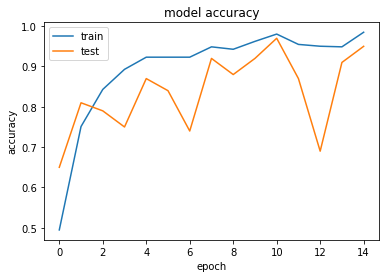

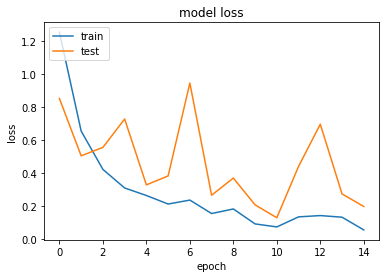

In [36]:
plot_loss_accuracy(result_conv2d_gru)

### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [38]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())



# epochs = 15
# batch size = 10
# num frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
    

In [39]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, augment=True, x=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames)

In [41]:
result_conv2d_gru2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_239/941690874.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result_conv2d_gru2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.2343 - categorical_accuracy: 0.4917Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_retrain_mobilenet_gru2_2024-05-0105_40_06.663523/model-00001-1.23433-0.49170-0.82345-0.65000.h5
67/67 [==============================] - 218s 3s/step - loss: 1.2343 - categorical_accuracy: 0.4917 - val_loss: 0.8234 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.5674 - categorical_accuracy: 0.7888
Epoch 00002: saving model to model_retrain_mobilenet_gru2_2024-05-0105_40_06.663523/model-00002-0.56744-0.78884-0.40935-0.85000.h5
67/67 [==============================] - 186s 3s/step - loss: 0.5674 - categorical_accuracy: 0.7888 - val_loss: 0.4093 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


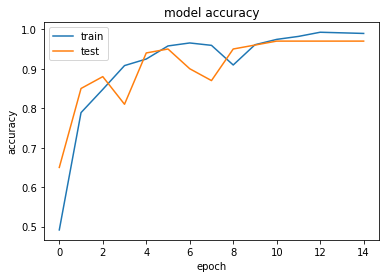

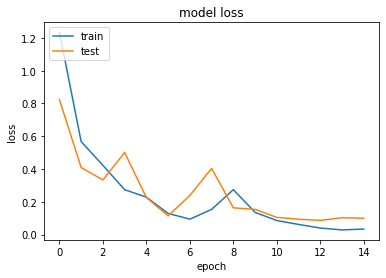

In [42]:
plot_loss_accuracy(result_conv2d_gru2)

#### Mobilenet (fine tune) + GRU (128 cells) + 128 dense nodes


In [13]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=True, gru=True, num_images=num_frames)
print(model.summary())

# epochs = 15
# batch size = 10
# num frames per video = 20


2024-05-01 13:51:17.565731: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-01 13:51:17.565831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Number of layers in the pretrained mobilenet model:  86
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 


In [14]:
callbacks_list = model_callbacks("model_finetune_mobilenet_gru_fine")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames)

In [15]:
model_finetune_mobilenet_gru_fine_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_234/1016011637.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_finetune_mobilenet_gru_fine_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15


2024-05-01 13:51:34.479416: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.1717 - categorical_accuracy: 0.5219Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_finetune_mobilenet_gru_fine_2024-05-0113_50_24.436042/model-00001-1.17171-0.52187-1.01397-0.66000.h5
67/67 [==============================] - 113s 2s/step - loss: 1.1717 - categorical_accuracy: 0.5219 - val_loss: 1.0140 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.5559 - categorical_accuracy: 0.7858
Epoch 00002: saving model to model_finetune_mobilenet_gru_fine_2024-05-0113_50_24.436042/model-00002-0.55592-0.78582-0.53628-0.78000.h5
67/67 [==============================] - 107s 2s/step - loss: 0.5559 - categorical_accuracy: 0.7858 - val_loss: 0.5363 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.3596 - categorical_accuracy: 0.8688
Epoch 00003: saving mo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


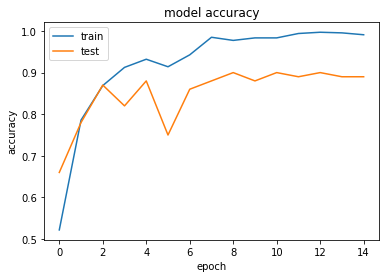

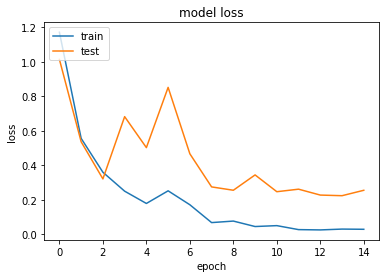

In [16]:
plot_loss_accuracy(model_finetune_mobilenet_gru_fine_result)

#### Mobilenet with False FineTune(re train all wieghts) + LSTM (128 cells) + 128 dense nodes


In [17]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 15
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
    

In [20]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames)

In [21]:
model_retrain_mobilenet_lstm_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_234/116961629.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_retrain_mobilenet_lstm_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.1902 - categorical_accuracy: 0.5023Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_retrain_mobilenet_lstm_2024-05-0113_50_24.436042/model-00001-1.19019-0.50226-0.90485-0.59000.h5
67/67 [==============================] - 112s 2s/step - loss: 1.1902 - categorical_accuracy: 0.5023 - val_loss: 0.9048 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.7399 - categorical_accuracy: 0.7014
Epoch 00002: saving model to model_retrain_mobilenet_lstm_2024-05-0113_50_24.436042/model-00002-0.73991-0.70136-0.54579-0.78000.h5
67/67 [==============================] - 107s 2s/step - loss: 0.7399 - categorical_accuracy: 0.7014 - val_loss: 0.5458 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


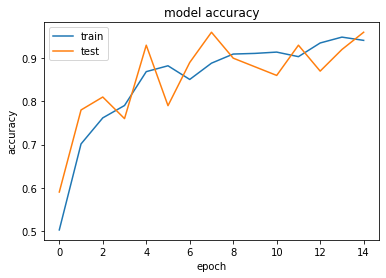

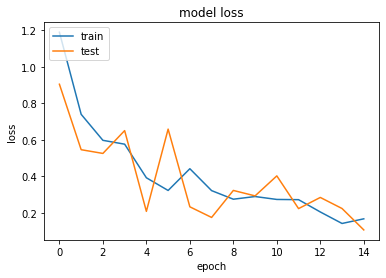

In [23]:
plot_loss_accuracy(model_retrain_mobilenet_lstm_result)

### Mobilenet (re train all weights) + 64 dense nodes

In [44]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=True, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 15
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [45]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, x=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, x=num_frames)

In [46]:
model_retrain_mobilenet_gru_64_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_239/2341239014.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_retrain_mobilenet_gru_64_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.1743 - categorical_accuracy: 0.5234Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_retrain_mobilenet_gru_64_2024-05-0105_40_06.663523/model-00001-1.17430-0.52338-0.85520-0.68000.h5
67/67 [==============================] - 125s 2s/step - loss: 1.1743 - categorical_accuracy: 0.5234 - val_loss: 0.8552 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.6176 - categorical_accuracy: 0.7768
Epoch 00002: saving model to model_retrain_mobilenet_gru_64_2024-05-0105_40_06.663523/model-00002-0.61759-0.77677-0.74458-0.73000.h5
67/67 [==============================] - 107s 2s/step - loss: 0.6176 - categorical_accuracy: 0.7768 - val_loss: 0.7446 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


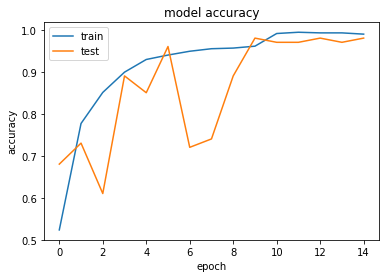

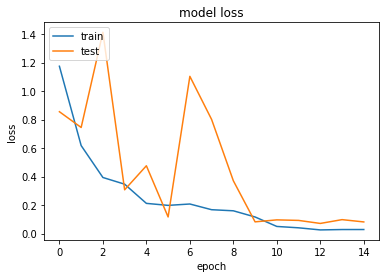

In [47]:
plot_loss_accuracy(model_retrain_mobilenet_gru_64_result)